# Lagged Correlation Analysis of Model

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore",message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.stats as stats
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import cmocean.cm as cm

In [276]:
mpl.rcParams['figure.dpi']= 300

In [4]:
def open_metric(var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'anom' or metric == 'mean':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

In [40]:
## adapted from esmtools.stats.corr and xskillscore.pearson_r
## --> https://esmtools.readthedocs.io/en/stable/index.html
## --> https://xskillscore.readthedocs.io/en/stable/index.html

## predictand = a
## predictor = b

def compute_lagged_corr_monthly(a, b, maxlead, lead_and_lag=False):
    
    ## helper function to compute lagged correlation
    def _lagged_corr(a, b, lead):
        a = a.values
        b = b.values
        
        ## get length of time series
        assert a.size == b.size, 'time series have different lengths'
        N = a.size
        
        normal = b[0 : N - lead]
        shifted = a[0 + lead : N]
        
        return stats.pearsonr(normal, shifted)
    
    if maxlead == 0:
        leadvalue = 0
        r, p = _lagged_corr(a, b, 0)
    
    else:
        if lead_and_lag:
            leadvalue = np.asarray(range(-maxlead, maxlead+1))
            r = np.zeros(2*maxlead+1)
            pvalue = np.zeros(2*maxlead+1)
        if not lead_and_lag:
            leadvalue = np.asarray(range(maxlead+1))
            r = np.zeros(maxlead+1)
            pvalue = np.zeros(maxlead+1)
    
        for (i, lead) in enumerate(leadvalue):
            if lead < 0:
                r[i], pvalue[i] = _lagged_corr(b, a, abs(lead))
            else:
                r[i], pvalue[i] = _lagged_corr(a, b, lead)

    return r, pvalue, leadvalue

In [32]:
def lagged_single_corr_heatmap(predictand_name, predictor_name, reg, threshold=0.75, hatch='//', cmap=cm.balance, figsize=(12,8)):  
    
    predictand = open_metric(predictand_name, 'so', 'anom')
    predictor = open_metric(predictor_name, 'so', 'anom')
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    if reg.lower() != 'all':
        predictand = predictand[reg]
        predictor = predictor[reg]
        
        maxlead = 119
        r, pvalue, leads = compute_lagged_corr_monthly(predictand, predictor, maxlead=maxlead)

        r_matrix = np.zeros((10,12))
        p_matrix = np.zeros((10,12))
        for m in range(r.size):
            r_matrix[int(m/12), m%12] = r[m]
            p_matrix[int(m/12), m%12] = pvalue[m]

        r_matrix = r_matrix.T
        p_matrix = p_matrix.T

        fig,ax = plt.subplots(figsize=figsize)
        im = ax.pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')

        ax.set_title(reg_names[reg])
        fig.suptitle(var_su_names[predictor_name]+' as a predictor of (leading) '+var_su_names[predictand_name], fontweight='bold')

        ax.set_yticks(np.arange(r_matrix.shape[0]) + 0.5)
        ax.set_yticklabels(abbrv_month_names)

        ax.set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
        ax.set_xticklabels(np.arange(1,11))
        ax.set_xlabel('Year')

        cb = fig.colorbar(im, label='Correlation coefficient', ax=ax)

        if hatch:
            masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
            masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

            cb.ax.plot([-1,1], [threshold,threshold], color='k')
            cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
            cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
            cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

        fig.tight_layout()

        return fig, ax
    
    elif reg.lower() == 'all':
        fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
        regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

        for (ix,reg) in enumerate(regions):
            tmp_predictand = predictand[reg]
            tmp_predictor = predictor[reg]
            
            maxlead = 119
            r, pvalue, leads = compute_lagged_corr_monthly(tmp_predictand, tmp_predictor, maxlead=maxlead)
            r_matrix = np.zeros((10,12))
        
            for m in range(r.size):
                r_matrix[int(m/12),m%12] = r[m]

            r_matrix = r_matrix.T

            im = ax[int(ix/3),ix%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')

            ax[int(ix/3),ix%3].set_title(reg_names[reg], fontweight='bold')

            ax[int(ix/3),ix%3].set_yticks(np.arange(r_matrix.shape[0]) + 0.5)
            ax[int(ix/3),ix%3].set_yticklabels(abbrv_month_names)

            ax[int(ix/3),ix%3].set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
            ax[int(ix/3),ix%3].set_xticklabels(np.arange(1,11,1))
            ax[int(ix/3),ix%3].set_aspect('auto')

            if int(ix/3) == 1:
                ax[int(ix/3),ix%3].set_xlabel('Year')

            if hatch:
                masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
                masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

        fig.suptitle(var_su_names[predictor_name]+' as a predictor of (leading) '+var_su_names[predictand_name], fontsize=14)
        fig.tight_layout()

        cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='Correlation coefficient')
        if hatch:
            cb.ax.plot([-1,1], [threshold,threshold], color='k')
            cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
            cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
            cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)
        
        return fig,ax

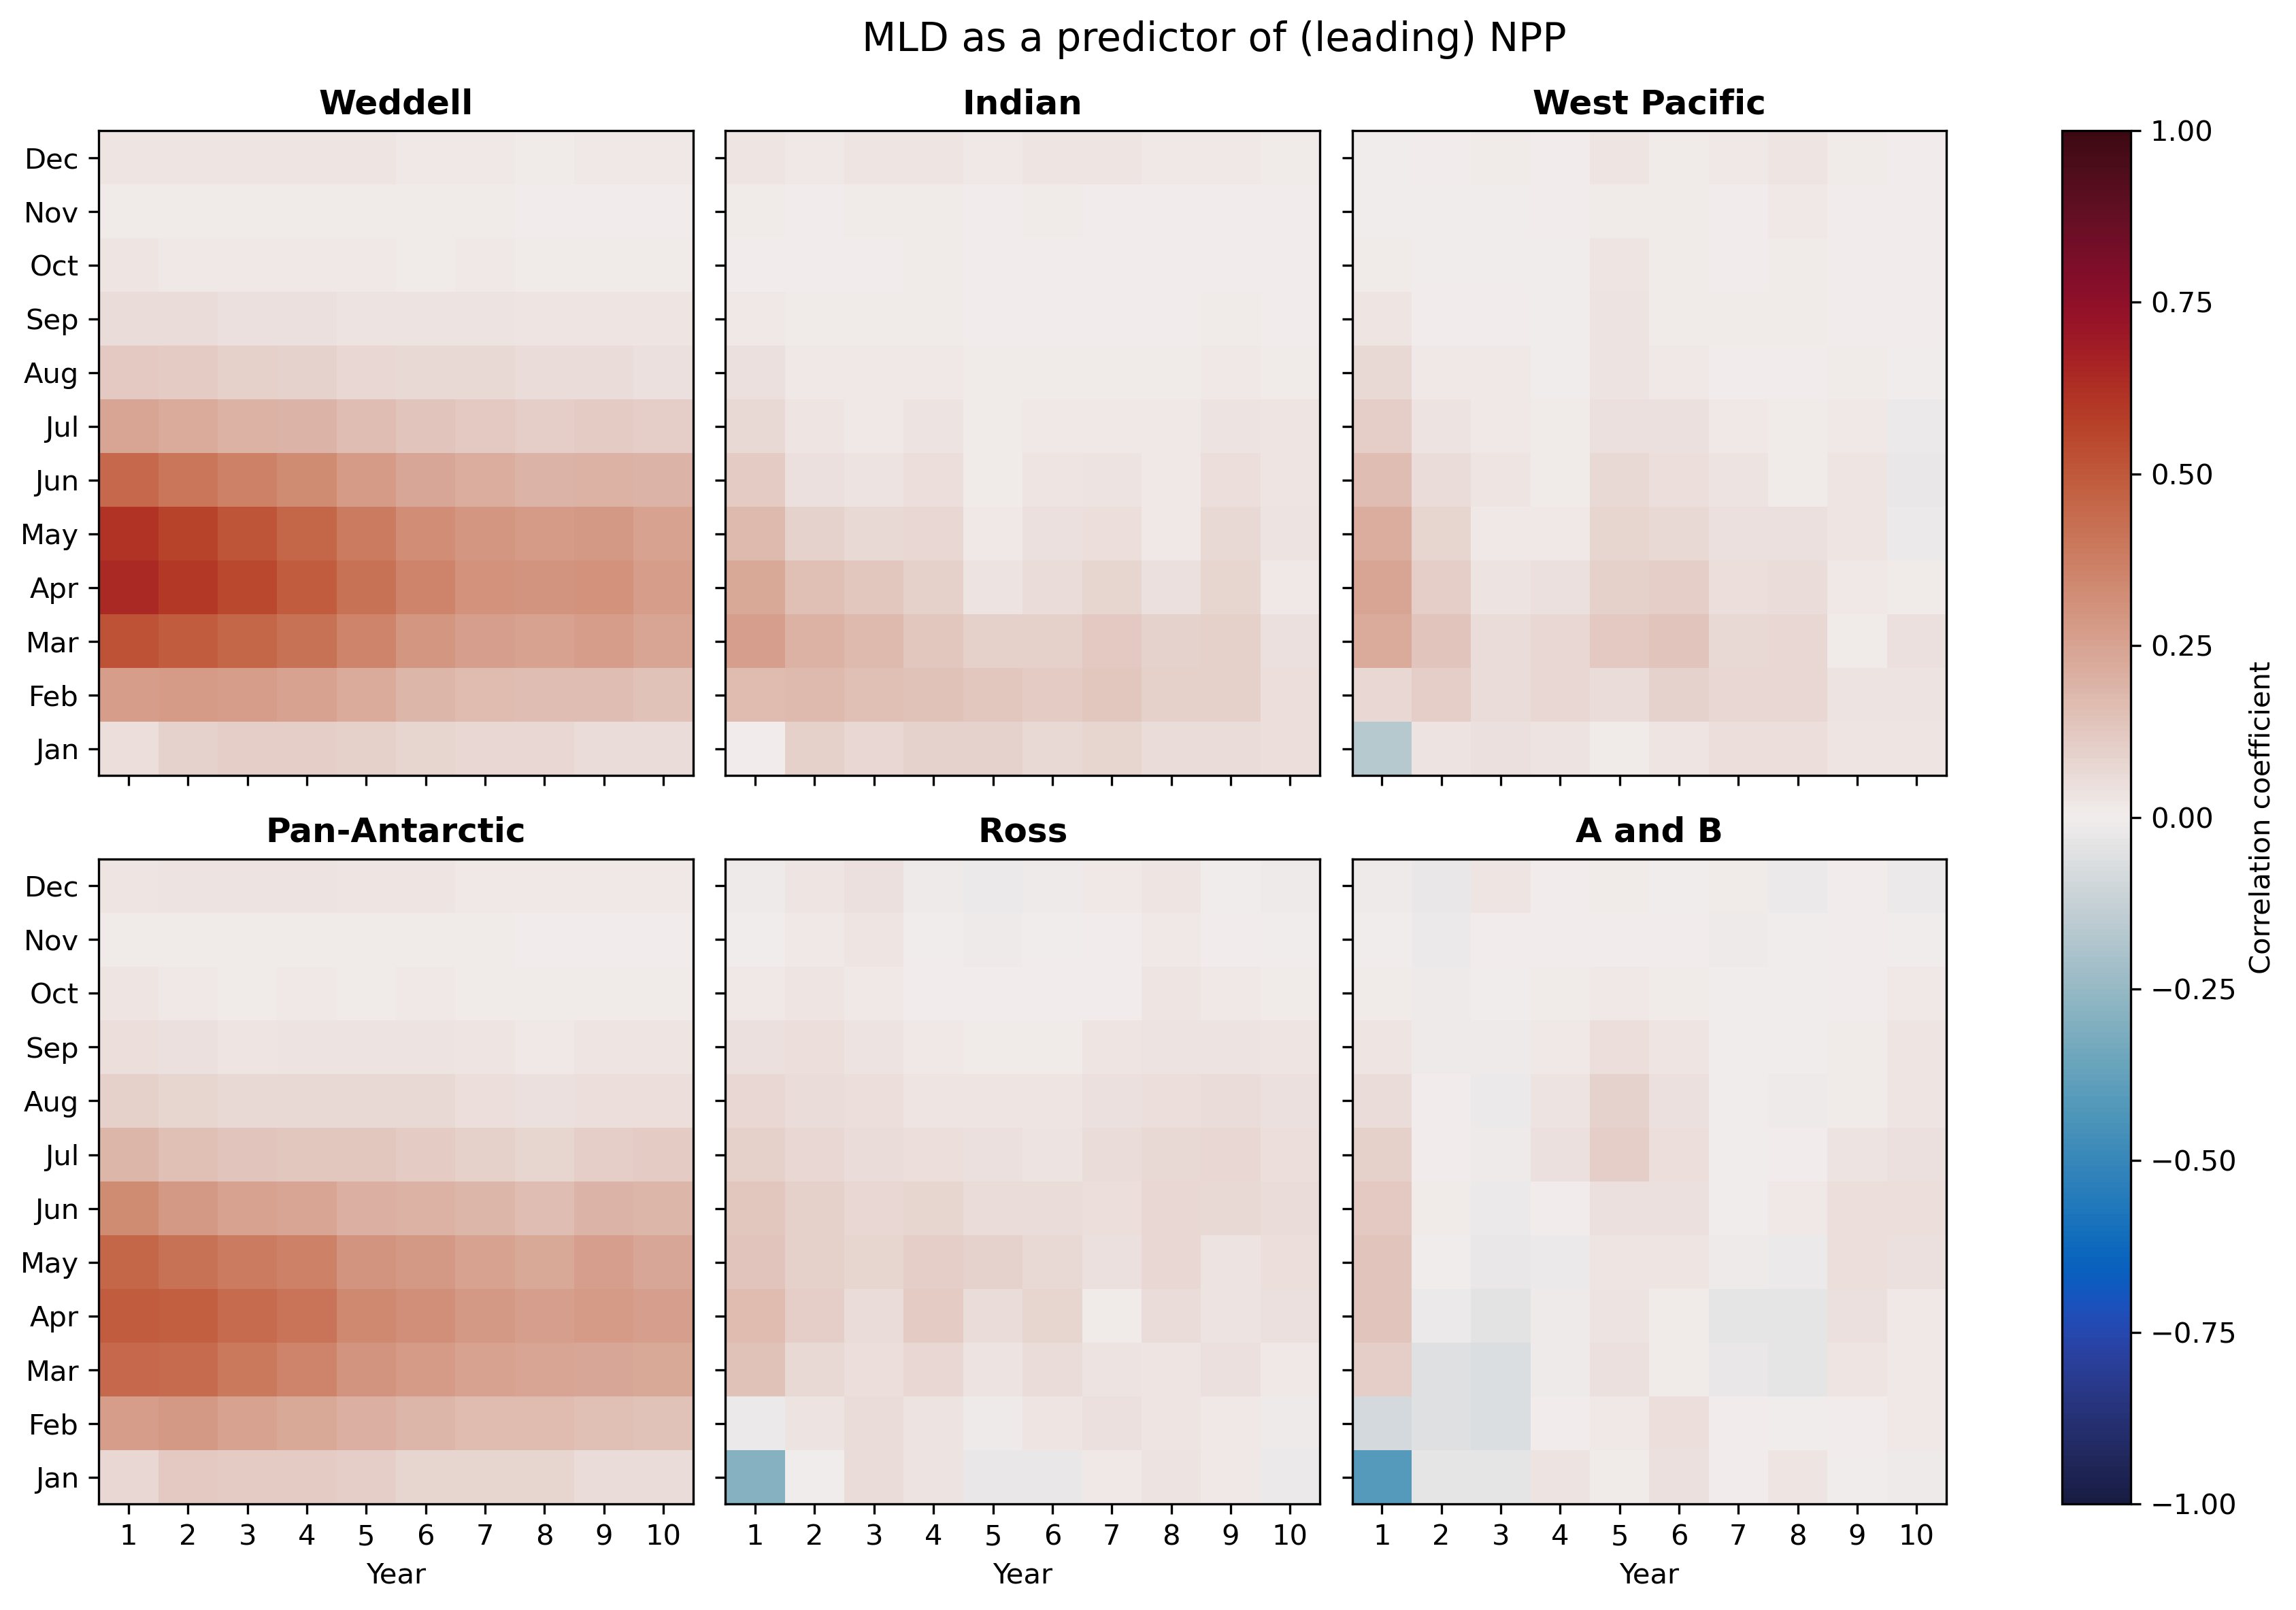

In [291]:
lagged_single_corr_heatmap('npp', 'mld', 'all', hatch=None);

In [281]:
def lagged_multiple_corr_heatmap(constant_variable, other_variables, maxlead, threshold=0.75, hatch='//', grid=False, yaxis_steps=2, cmap=cm.balance, figsize=(9,7)):
    constant = open_metric(constant_variable, 'so', 'anom')
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']
    variable_names = []
    
    fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
    
    for (ireg,reg) in enumerate(regions):
        tmp_constant = constant[reg]
        r_matrix = np.zeros((len(other_variables), 2*maxlead+1))
        p_matrix = np.zeros((len(other_variables), 2*maxlead+1))
        lead_matrix = np.zeros((len(other_variables), 2*maxlead+1))
        
        for (ivar,var) in enumerate(other_variables):
            if ireg == 0: variable_names.append(var_su_names[var])
            tmp_other = open_metric(var, 'so', 'anom')[reg]
            r, pvalue, leads = compute_lagged_corr_monthly(tmp_constant, tmp_other, maxlead, True)
            
            r_matrix[ivar] = r
            p_matrix[ivar] = pvalue
            lead_matrix[ivar] = leads
            
        r_matrix = r_matrix.T
        p_matrix = p_matrix.T
        lead_matrix = lead_matrix.T
        
        if grid:
            im = ax[int(ireg/3),ireg%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto', edgecolor='dimgray', linewidth=0.01)
        elif not grid:
            im = ax[int(ireg/3),ireg%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')
        
        ## print lead values on plot
#         if int(ireg/3) == 0 and ireg%3 == 0:
#             for (i, j), z in np.ndenumerate(lead_matrix):
#                 ax[int(ireg/3),ireg%3].text(j+0.5, i+0.5, '%3d'%z, ha='center', va='center', fontsize=4)
        
        ax[int(ireg/3),ireg%3].set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
        ax[int(ireg/3),ireg%3].set_xticklabels(variable_names)
        plt.setp(ax[int(ireg/3),ireg%3].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        ax[int(ireg/3),ireg%3].set_yticks(np.arange(0, 2*maxlead+1, yaxis_steps) + 0.5)
        ax[int(ireg/3),ireg%3].set_yticklabels(['%3d' % m for m in lead_matrix.T[0]][0:2*maxlead+1:yaxis_steps])
        if ireg%3 == 0:
            ax[int(ireg/3),ireg%3].set_ylabel('Lead (months)')
        
#         ax[int(ireg/3),ireg%3].set_yticks(np.arange(0,r_matrix.shape[0],yaxis_steps) + 0.5)
#         mult = int(maxlead/12)+1
#         ylabels = (abbrv_month_names*mult)[0:maxlead:yaxis_steps]
#         ylabels += ylabels
#         for (i,yr) in zip(range(len(ylabels)), range(0,maxlead,yaxis_steps)):
#             if ylabels[i] == 'Jan':
#                 ylabels[i] = str(yr//12 + 1)+'   '+ylabels[i]
#         ax[int(ireg/3),ireg%3].set_yticklabels(ylabels)

        ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontsize='x-large', fontweight='bold')
    
        if hatch:
            masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
            masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)

    fig.suptitle('correlation to '+var_su_names[constant_variable], ha='right')
    fig.tight_layout()
    
    cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='correlation coefficient')

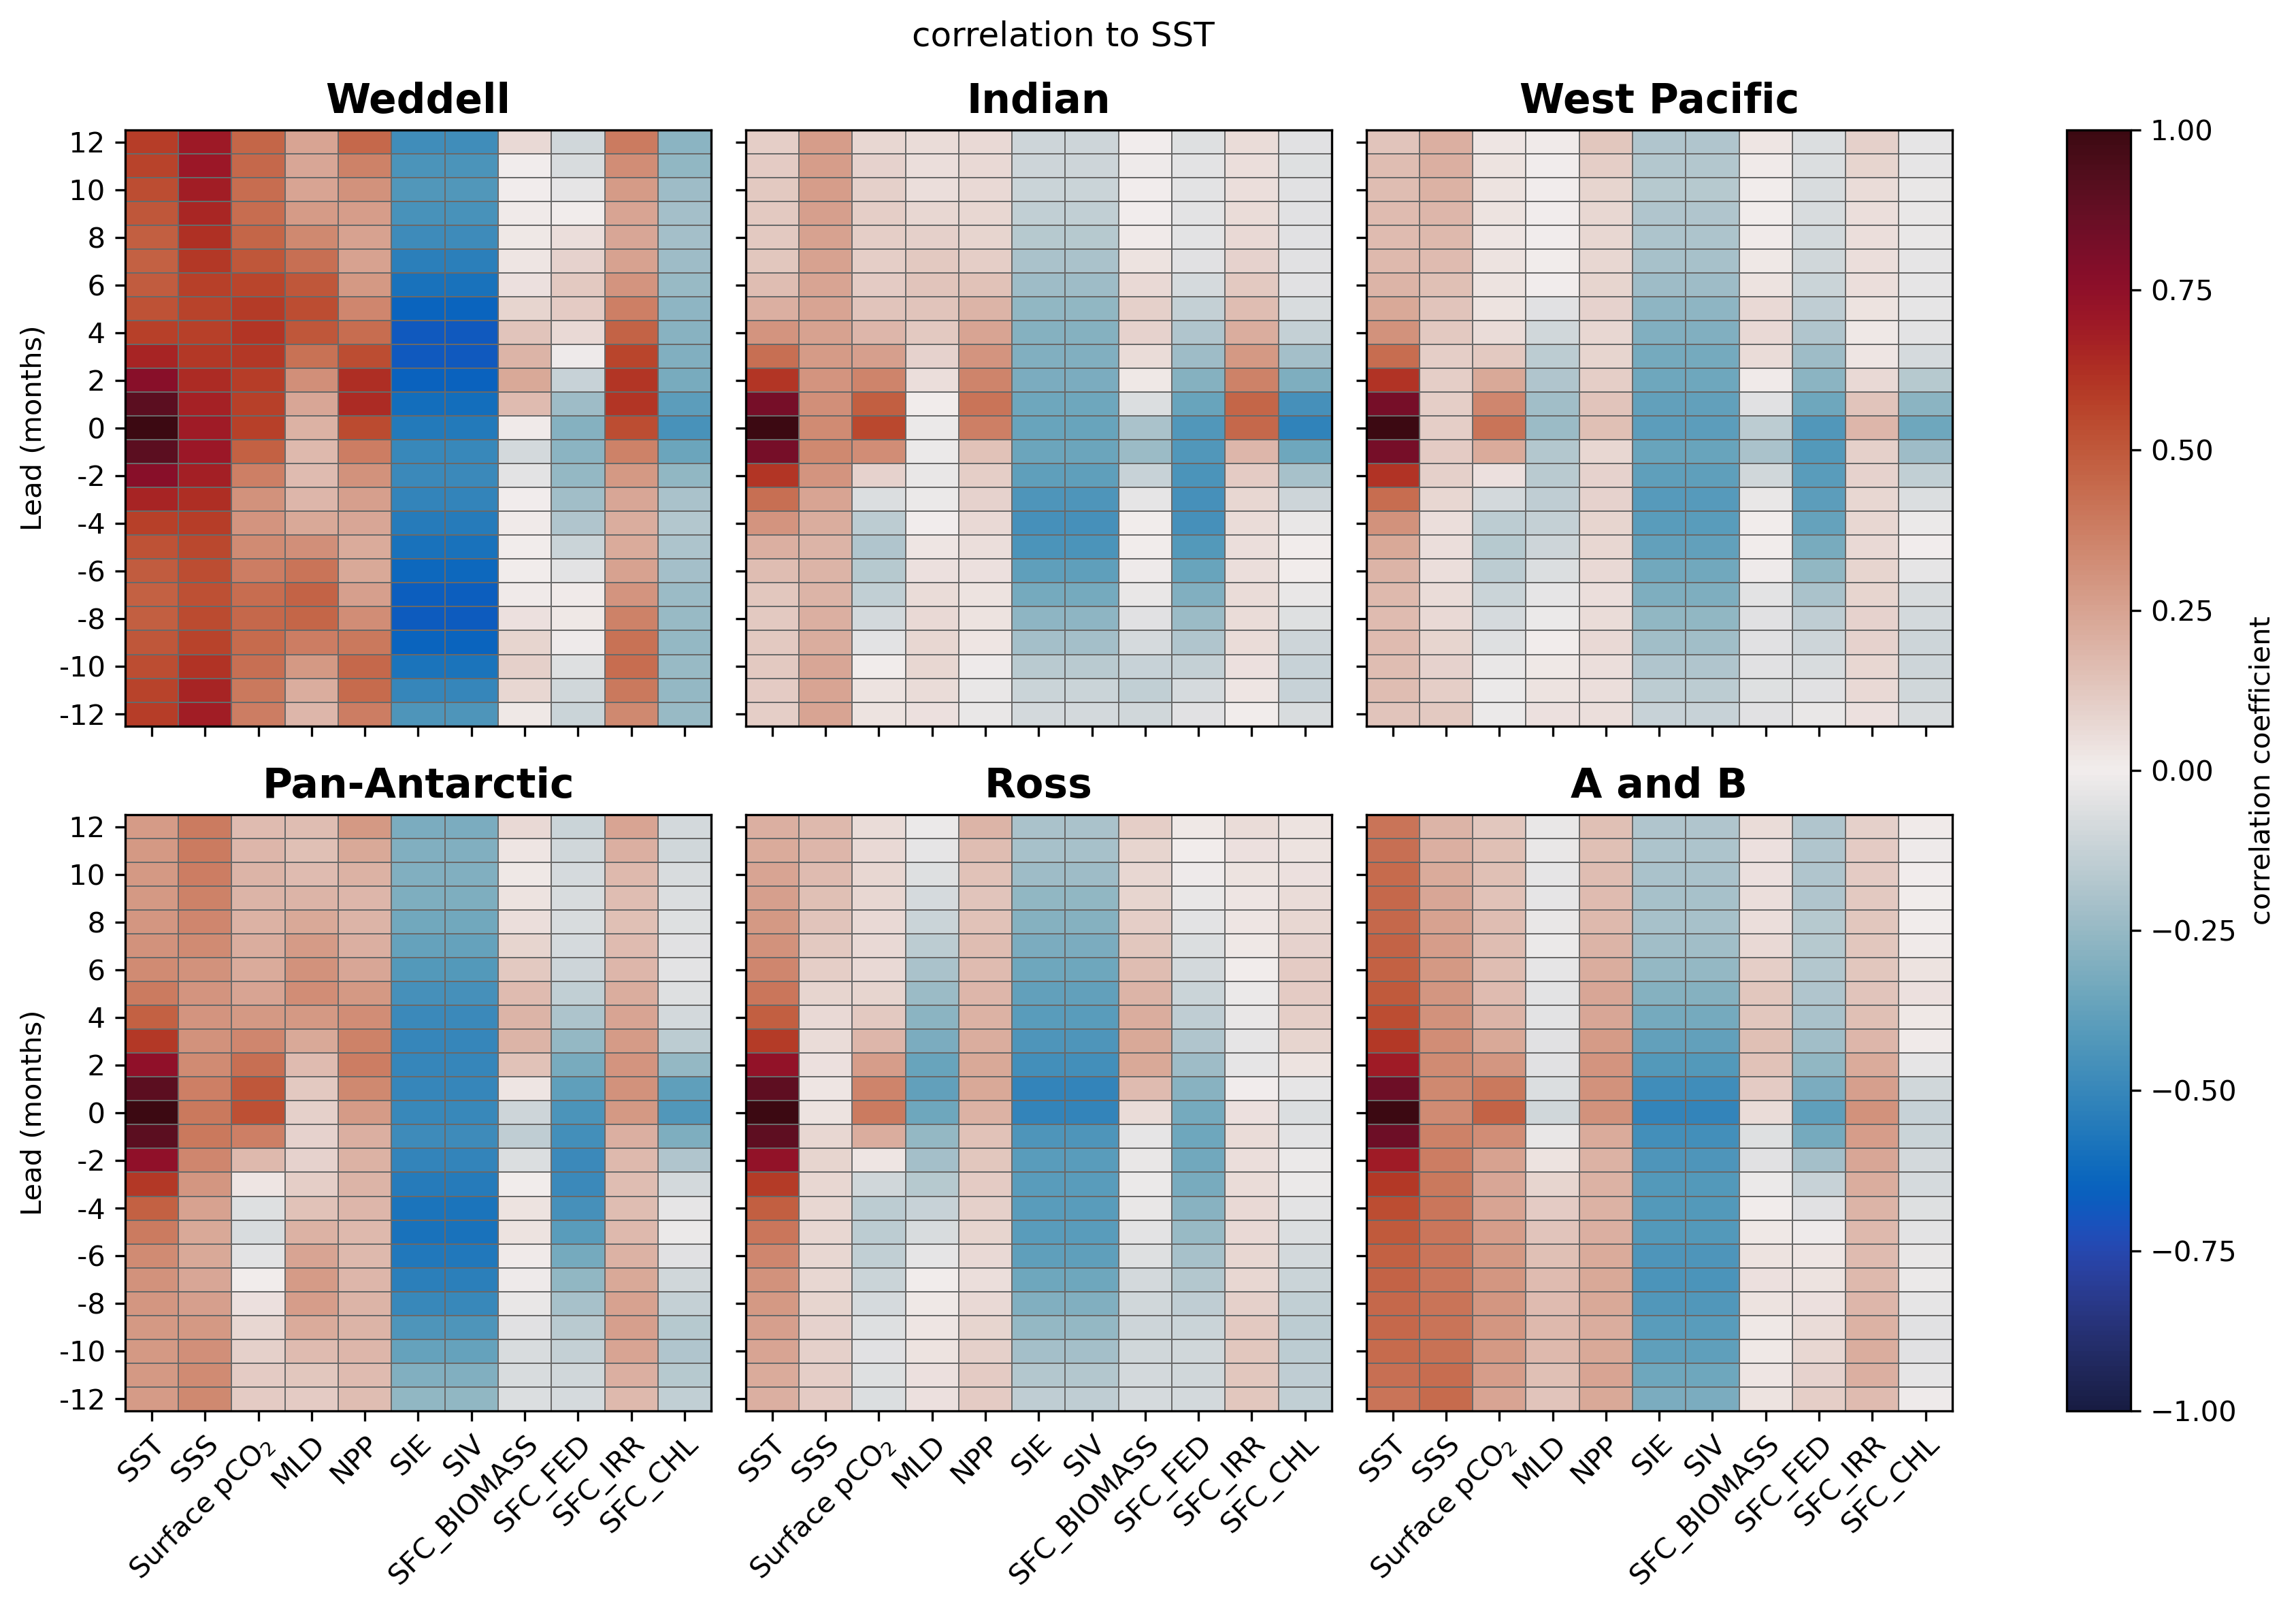

In [289]:
variables = ['sst', 'sss', 'pco2surf', 'mld', 'npp', 'sie', 'siv', 'sfc_biomass', 'sfc_fed', 'sfc_irr', 'sfc_chl']
lagged_multiple_corr_heatmap('sst', variables, maxlead=12, hatch=False, grid=True, figsize=(12,8))